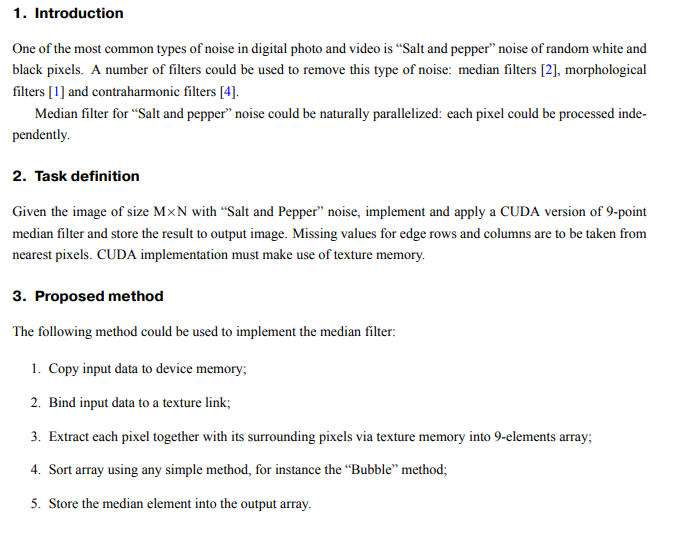

In [1]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.9 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2023.1-cp310-cp310-linux_x86_64.whl size=661205 sha256=92c43bc85bd906ee9c452e8d75a907dde7f1378e7bc149865ab3bf344e5e1fd0
  Stored in directory: /root/.cache/pip/wheels/46/65/06/b997165edd2fd9690c3497ca54ea4485b571d7bd959c21c6c4
Successfully built pycuda


In [2]:
!pip install py-cpuinfo

In [3]:
!nvidia-smi

Fri Dec 15 08:42:07 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Изображения я буду загружать с гугл диска

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from google.colab.patches import cv2_imshow

In [57]:
import numpy as np
import numba
from numba import cuda
import math
from time import time
from PIL import Image

Реализация функции для зашумления изображения Salt and pepper

In [65]:
# Добавление шума "Salt and pepper"
def add_salt_and_pepper_noise(image, prob):
    rnd = np.random.rand(image.shape[0], image.shape[1])
    noisy = image.copy()
    noisy[rnd < prob] = 0
    noisy[rnd > 1 - prob] = 255
    return noisy

**Медианный фильтр на CPU**

In [67]:
# Медианный фильтр на CPU
def apply_median_filter_cpu(a):
    b = a.copy()
    start = time()
    for i in range(2, len(a) - 1):
        for j in range(2, len(a[i]) - 1):
            t = [0, 0, 0, 0, 0, 0, 0, 0, 0]

            t[0], t[1], t[2], t[3], t[4], t[5], t[6], t[7], t[8] = a[i-1][j-1], a[i-1][j], a[i-1][j+1], a[i][j-1], a[i][j], a[i][j+1], a[i+1][j-1], a[i+1][j], a[i+1][j+1]

            for k in range(8):
                for l in range(8-k):
                    if t[l] > t[l+1]:
                        t[l], t[l+1] = t[l+1], t[l]
            b[i][j] = t[int(len(t)/2)]
    return b, time() - start

**Медианный фильтр на GPU**

In [69]:
@cuda.jit
# Медианный фильтр на GPU
def apply_median_filter_gpu(a, b):
    i, j = cuda.grid(2)
    t = cuda.local.array(shape=9, dtype=numba.int64)

    t[0], t[1], t[2], t[3], t[4], t[5], t[6], t[7], t[8] = a[i-1][j-1], a[i-1][j], a[i-1][j+1], a[i][j-1], a[i][j], a[i][j+1], a[i+1][j-1], a[i+1][j], a[i+1][j+1]

    for k in range(8):
        for l in range(8-k):
            if t[l] > t[l+1]:
                t[l], t[l+1] = t[l+1], t[l]
    b[i][j] = t[int(len(t)/2)]

In [70]:
# Подготовка и выполнение медианного фильтра на GPU
def prepare_and_execute_gpu(a):
    b = a.copy()
    thread_number_block = 32

    a_global = cuda.to_device(a)
    b_global = cuda.to_device(b)

    threadsperblock = (thread_number_block, thread_number_block)
    blockspergrid_x = int(math.ceil(a.shape[0] / threadsperblock[1]))
    blockspergrid_y = int(math.ceil(b.shape[1] / threadsperblock[0]))
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    start = time()
    apply_median_filter_gpu[blockspergrid, threadsperblock](a_global, b_global)
    return b_global.copy_to_host(), time() - start

Объединю все функции для удобства

In [92]:
# Эксперимент с изображением
def test(name, salt):
    im = Image.open(name).convert('L')
    img_width, img_height = im.size # Получение размеров изображения

    if salt == True:
        display(im)
    img_array = np.array(im)

    img_array = add_salt_and_pepper_noise(img_array, 0.02)
    if salt == True:
        display(Image.fromarray(np.uint8(img_array)))
        noisy_img = Image.fromarray(np.uint8(img_array))
        noisy_img.save('salt.jpg')

    filtered_img_cpu, c_time = apply_median_filter_cpu(img_array)

    if salt == True:
        display(Image.fromarray(np.uint8(filtered_img_cpu)))
        cpu_img = Image.fromarray(np.uint8(filtered_img_cpu))
        cpu_img.save('cpu.jpg')

    filtered_img_gpu, g_time = prepare_and_execute_gpu(img_array)

    if salt == True:
        display(Image.fromarray(np.uint8(filtered_img_gpu)))
        gpu_img = Image.fromarray(np.uint8(filtered_img_gpu))
        gpu_img.save('gpu.jpg')
    n = len(img) * len(img[0])
    total_elements = len(img_array) * len(img_array[0])
    print('Размеры изображения =', img_width, 'x', img_height)
    print('Время выполнения на CPU =', c_time)
    print('Время выполнения на GPU =', g_time)
    print('Ускорение =', c_time/g_time)
    print()

    return c_time/g_time, total_elements

In [90]:
IMG = '/content/drive/MyDrive/MyData/image1.jpg'

1. Тест на изображении размером  960 x 538

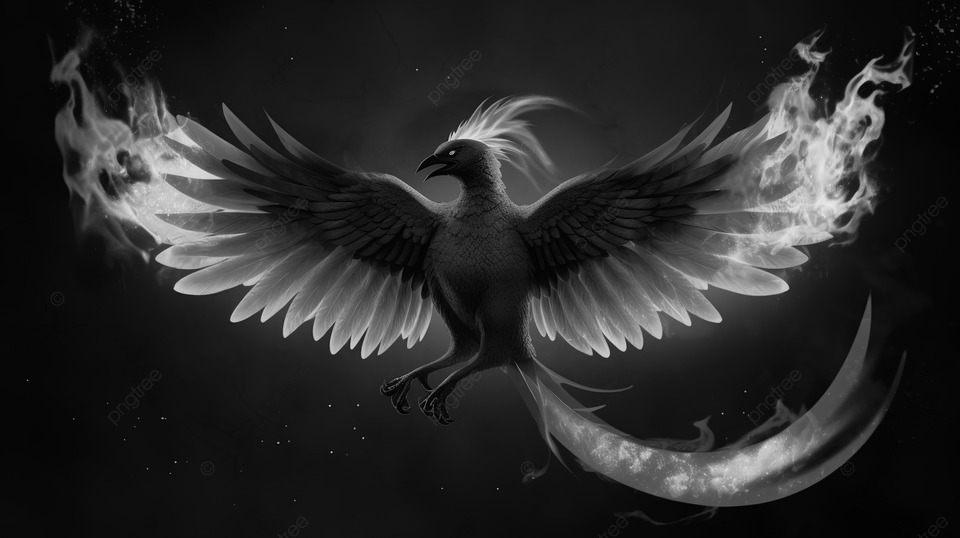

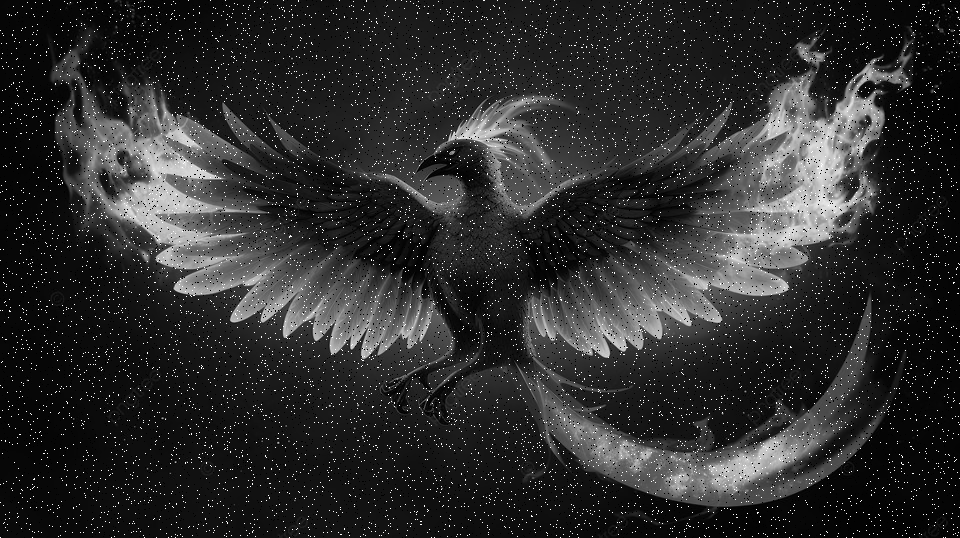

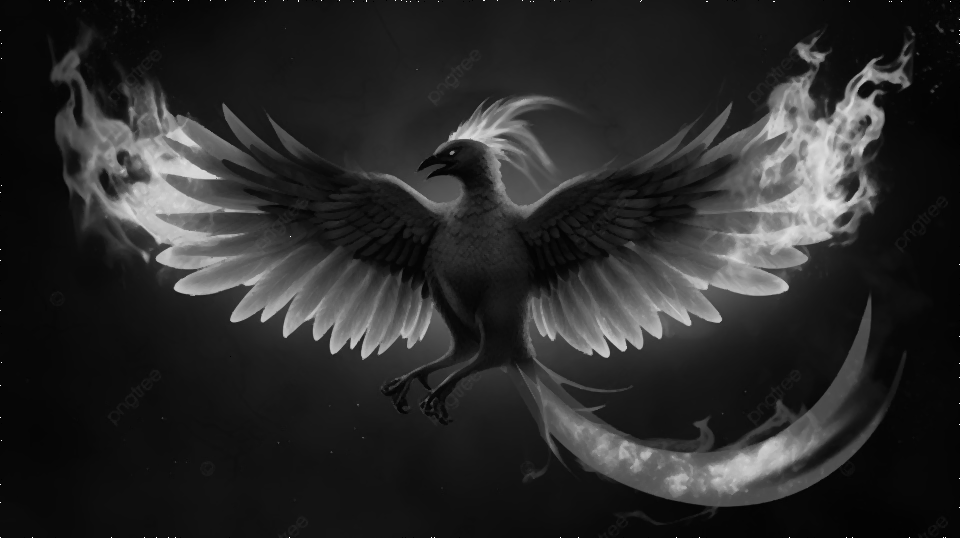

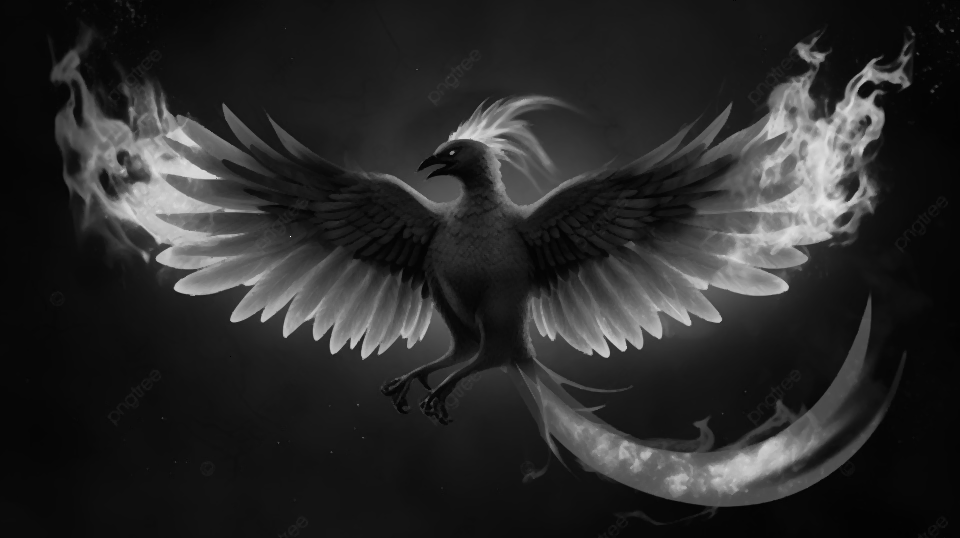

Размеры изображения = 960 x 538
Время выполнения на CPU = 6.971456050872803
Время выполнения на GPU = 0.001009225845336914
Ускорение = 6907.7264351523745



In [93]:
a1, n1 = test(IMG, True)

**Размеры изображения** = 960 x 538

**Время выполнения на CPU** = 6.971456050872803

**Время выполнения на GPU** = 0.001009225845336914

**Ускорение** = 6907.7264351523745

2. Тест на изображении размером  2160 x 1215

In [98]:
IMG2 = '/content/drive/MyDrive/MyData/image2.jpg'

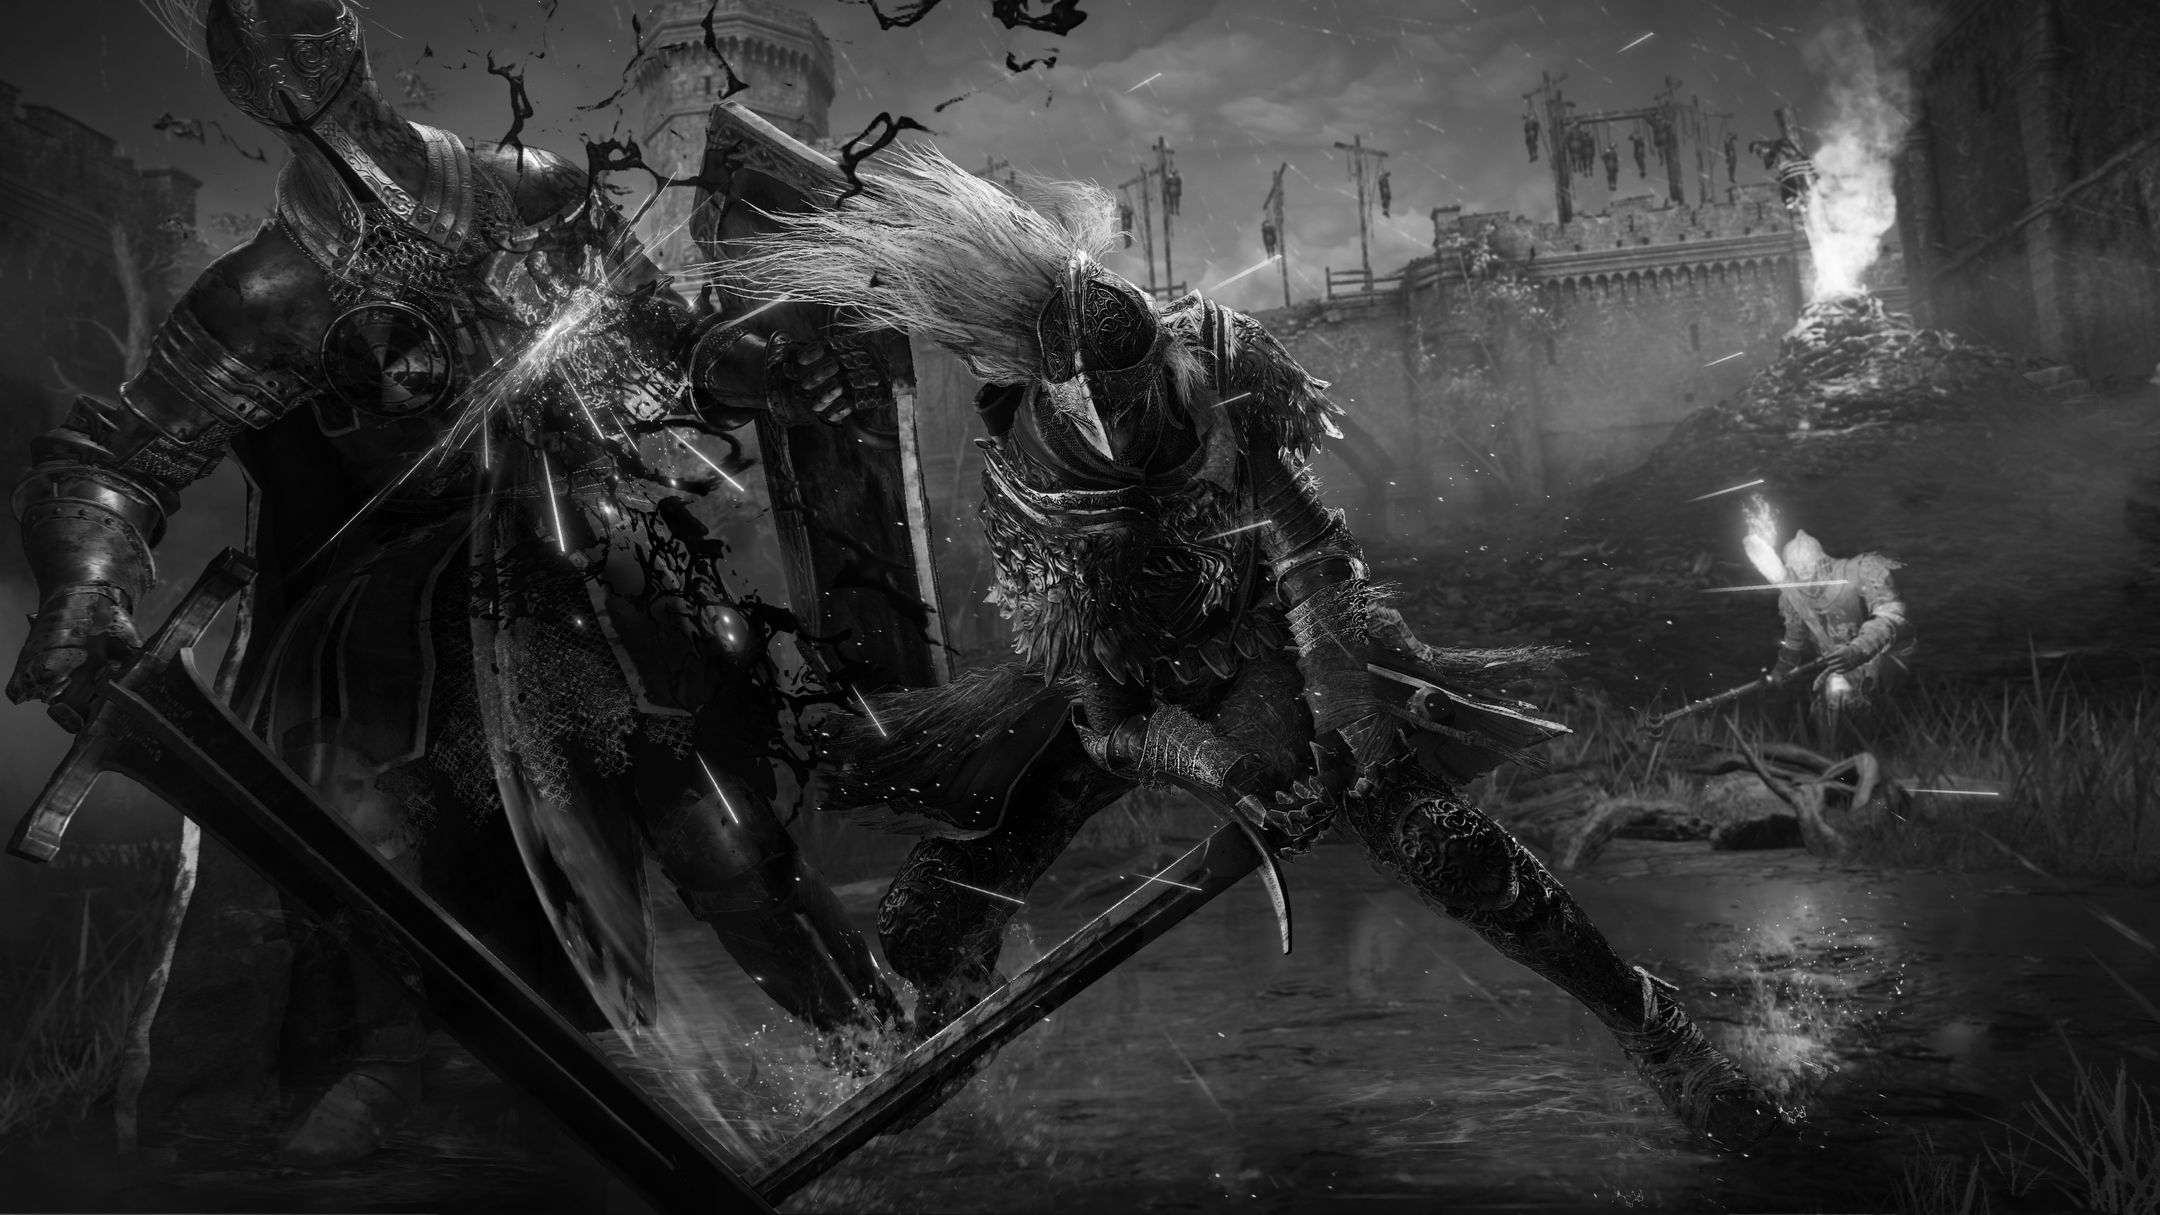

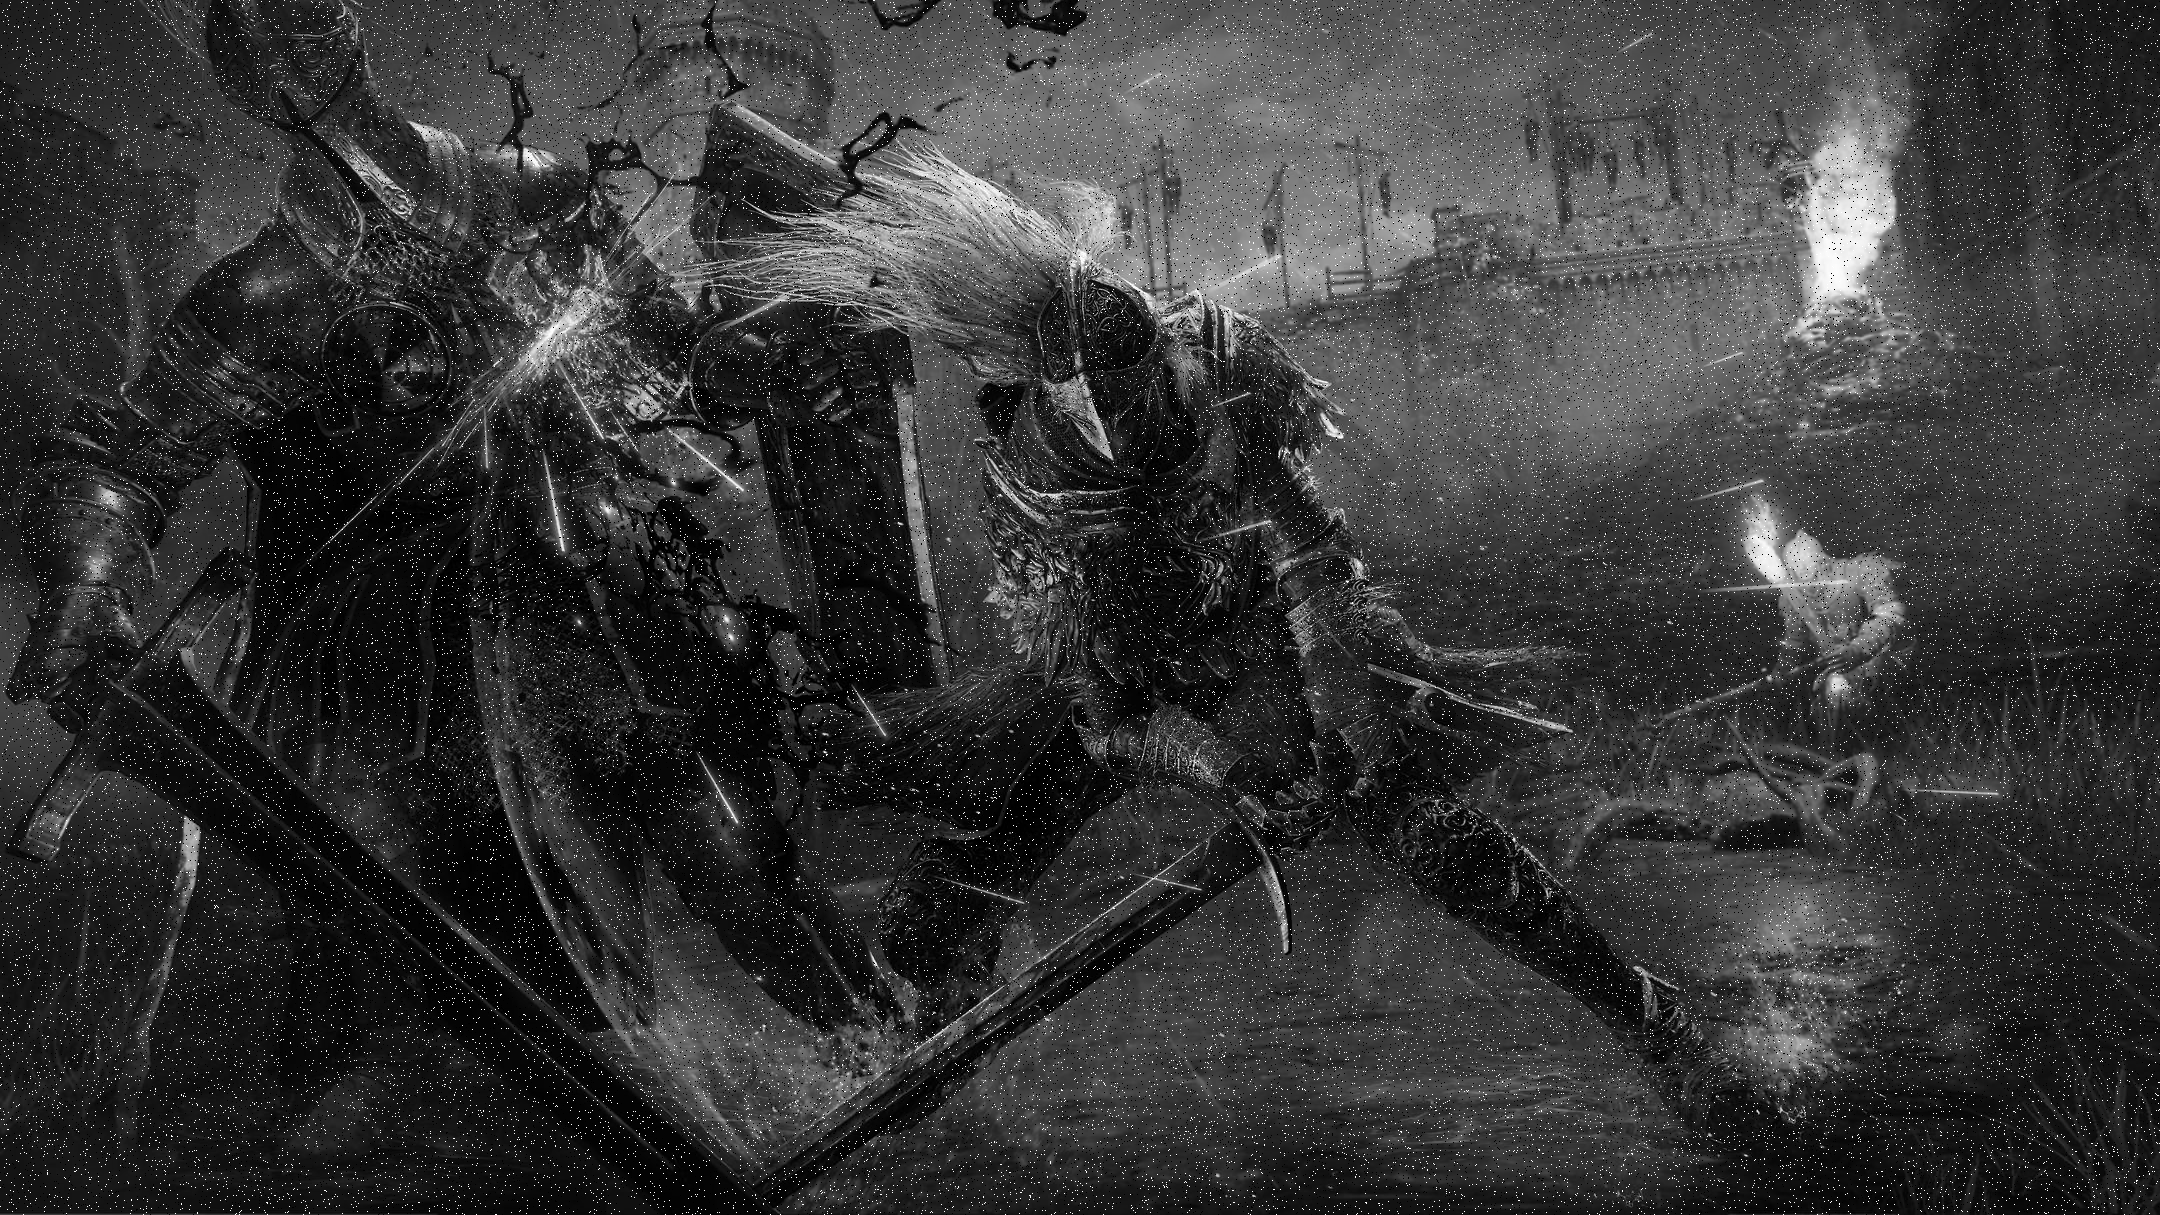

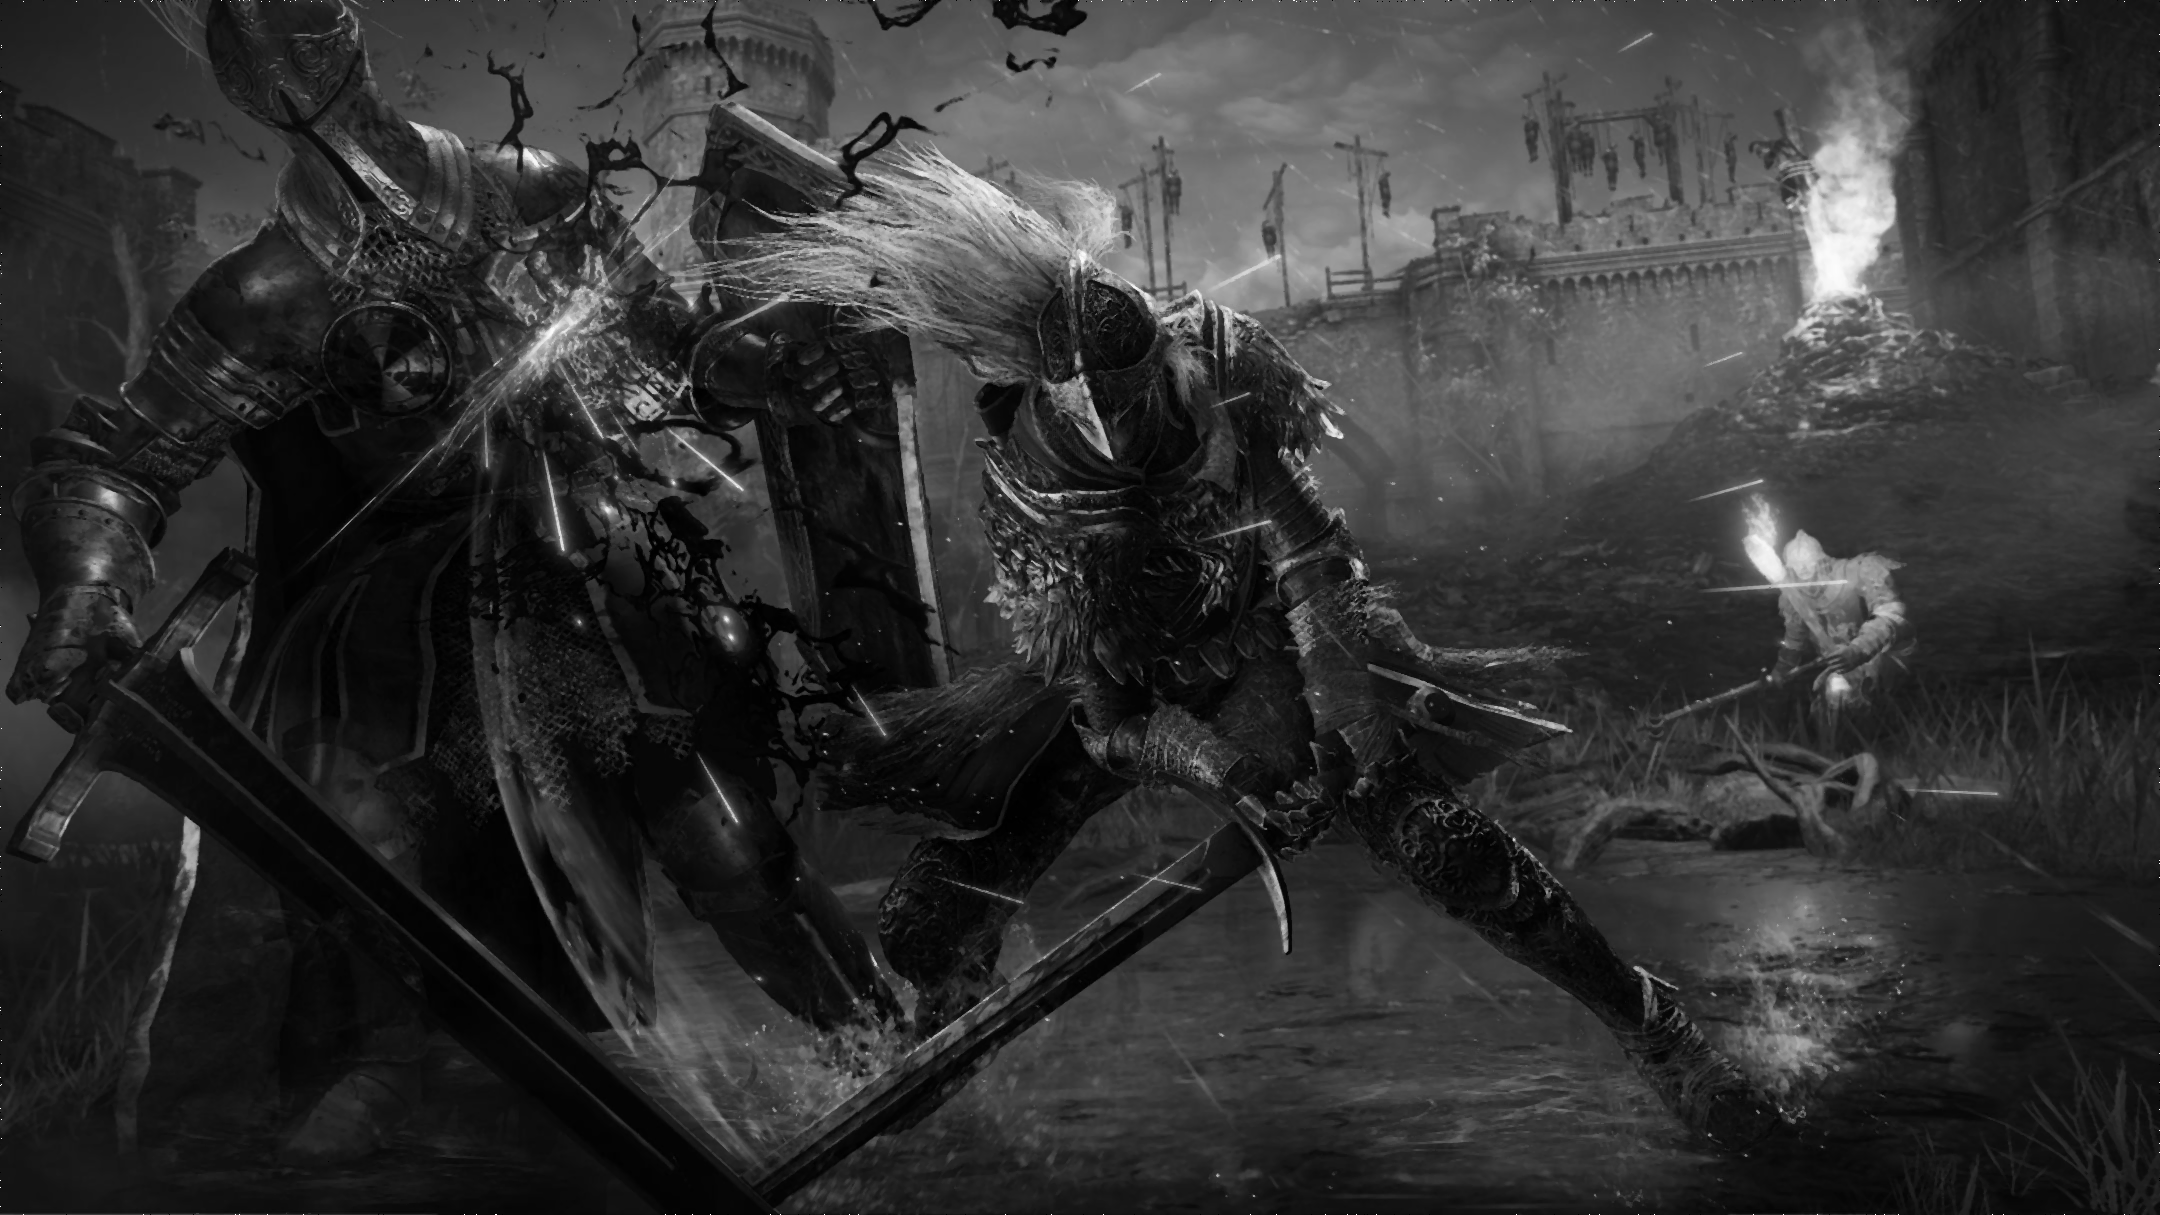

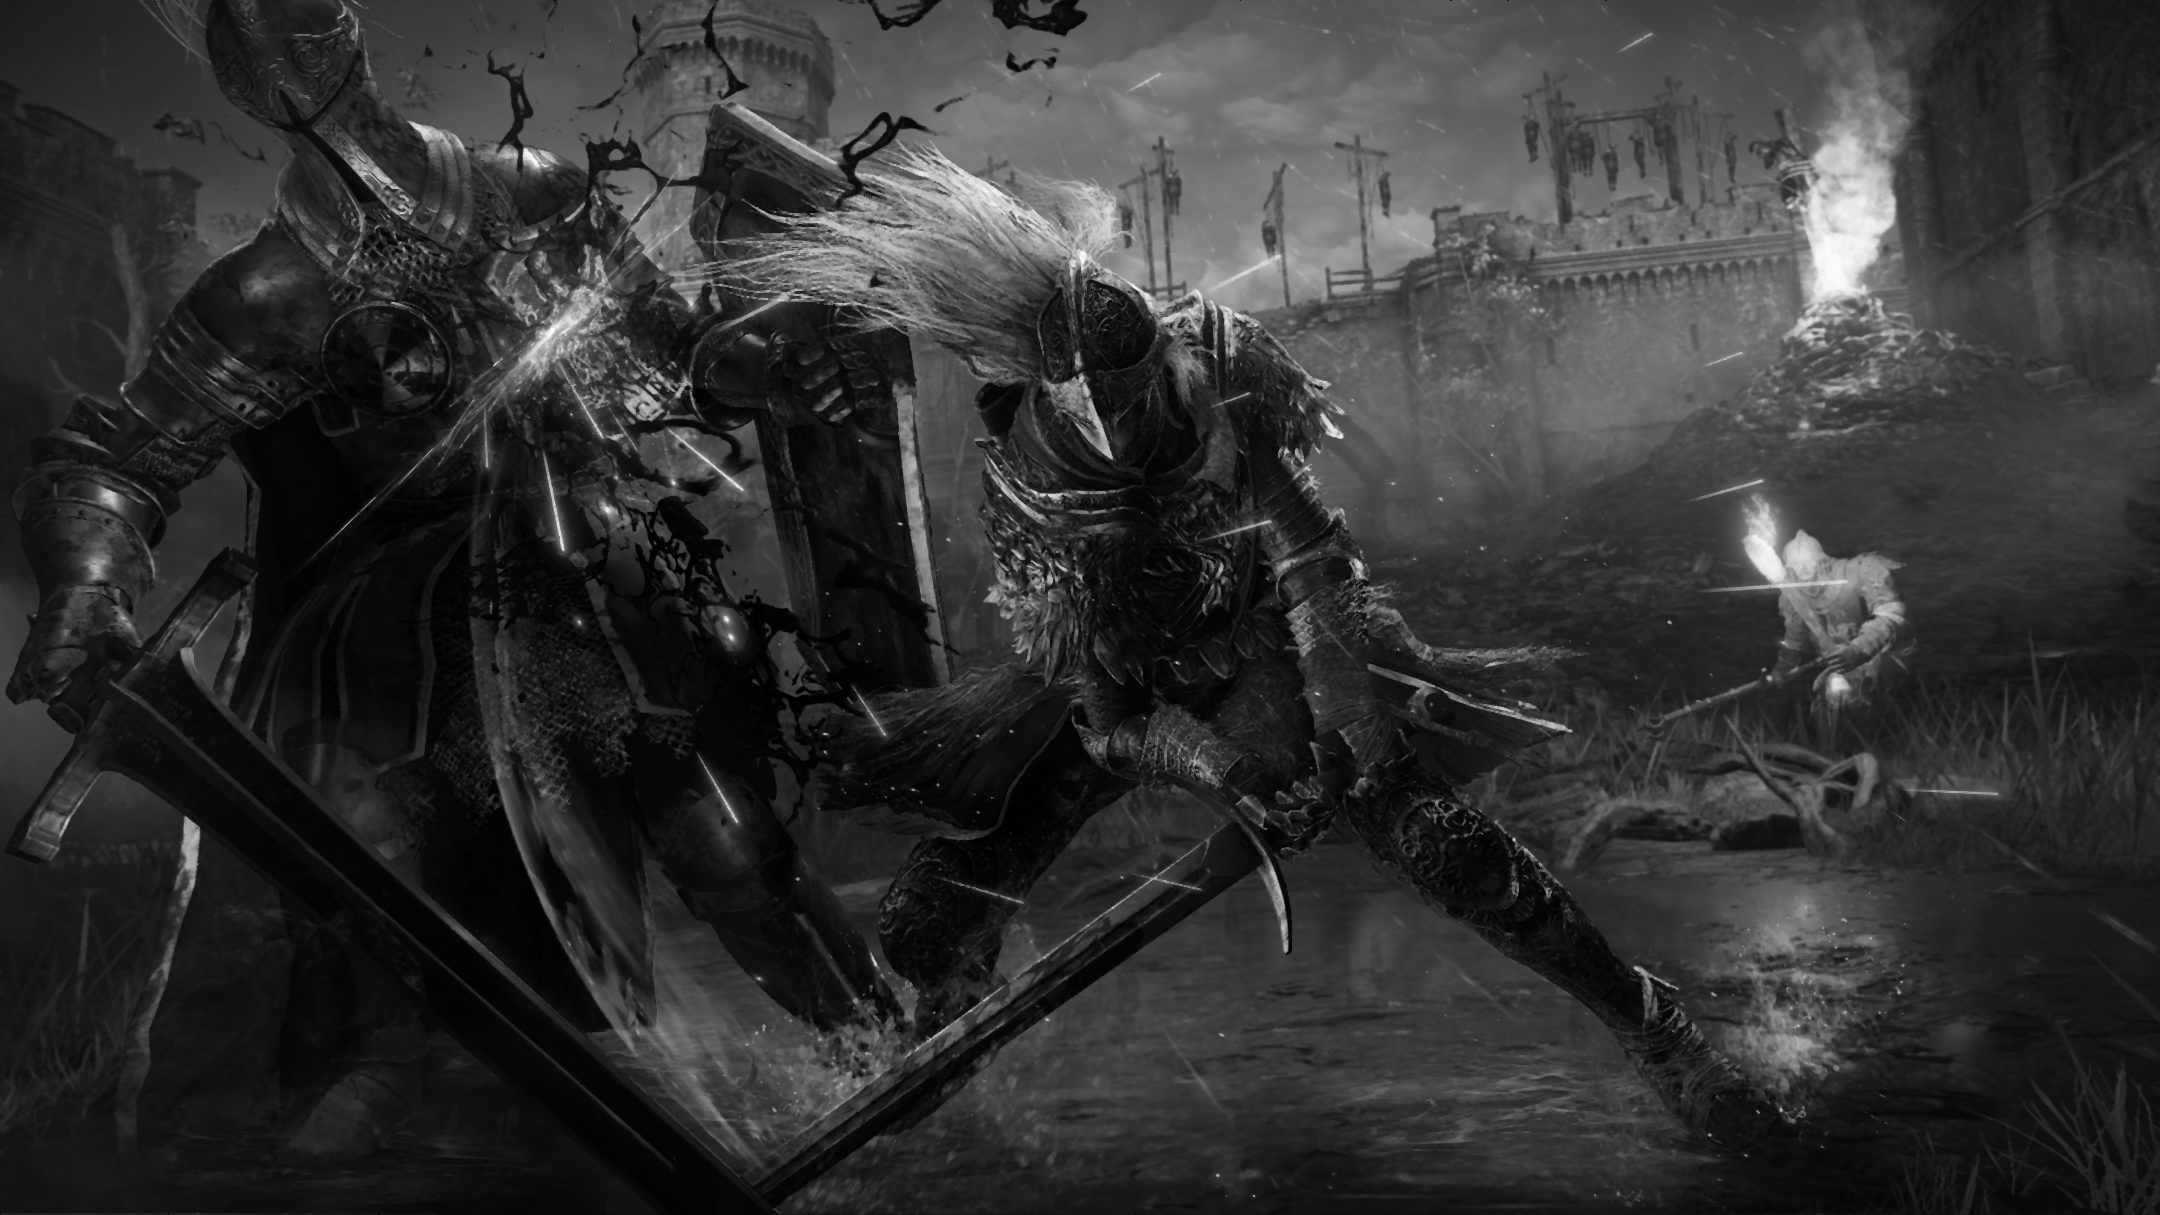

Размеры изображения = 2160 x 1215
Время выполнения на CPU = 29.8856999874115
Время выполнения на GPU = 0.002511262893676758
Ускорение = 11900.665622329821



In [99]:
a2, n2 = test(IMG2, True)

**Размеры изображения** = 2160 x 1215

**Время выполнения на CPU** = 29.8856999874115

**Время выполнения на GPU** = 0.002511262893676758

**Ускорение** = 11900.665622329821